# Minimal PYMC for Flash Analysis
(3/1/2016 Jozef Gembarovic)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc
import scipy.stats as stats
import pymc
#  the sampler
from pyhmc import hmc

%matplotlib inline
np.random.seed(1234)

In [2]:
# import flash rise data from a fdata2.csv file
data = np.loadtxt('fdata2.csv', delimiter=',')
#N=20 
#t = np.linspace(0.001,2.5,N)
sigma = 0.01
a_theor = 0.5 # alpha
b_theor = 0.25 # Biot number
c_theor = 0.75 # tmax

## 1DHL flash method response

### One Dimensional Model with heat losses
Analytical formula for temperature response at the rear face of the sample ($x=L$, $t>0$) is
$$ T(t, a, B_1, B_2) = \sum_{i=0}^\infty \frac{ 2\gamma_i^2(\gamma_i^2+B_2^2)\big(\cos{\gamma_i}+\frac{B_1}{\gamma_i}\sin{\gamma_i}\big)}{(\gamma_i^2+B_1^2)(\gamma_i^2+B_2^2)+(B_1+B_2)(\gamma_i^2+B_1B_2)}\exp{\big[-\gamma_i^2\frac{at}{L^2}\big]}, $$
where $\gamma_i$, $i=1,2,3,\dots$, are positive roots of 
$$ (\gamma^2-B_1B_2)\sin{\gamma} - (B_1+B_2)\cos{\gamma}=0.$$

$B_1$ and $B_2$ are Biot numbers for the front and rear side of the sample, resp. 

In [3]:
import scipy.special as scs # for Bessel functions (special functions in the Scientific Python package)
from scipy.optimize import brenth # for finding zero of a function
#  conda install -c https://conda.anaconda.org/omnia pyhmc
# transcendental functions for eigenvalues calculations
def funA(x,bio): 
    return (x*x - bio**2)*np.sin(x) - (2*bio)*x*np.cos(x)
    

# define Biot numbers for front, rear, radial of a cylindrical shape sample
L = 1
#R = 5
#Biot_theor = 0.1
#Bio = Biot_theor

def rootsearch(f,a1,b1,Bio,dx):
    x1 = a1; f1 = f(a1, Bio)
    x2 = a1 + dx; f2 = f(x2, Bio)
    while f1*f2 > 0.0:
        if x1 >= b1:
            return None,None
        x1 = x2; f1 = f2
        x2 = x1 + dx; f2 = f(x2, Bio)
    return x1,x2


def mroots(f, Bio, a1, b1, eps=1e-2):
    #print ('The roots on the interval [%f, %f] are:' % (a,b))
    i=0
    myroots=[]
    while 1:
        x1,x2 = rootsearch(f,a1,b1,Bio,eps)
        if x1 != None:
            a1 = x2
            #root = bisect(f,x1,x2,1)
            root = brenth(f,x1,x2, Bio, xtol=1e-16)
            if root != None:
                pass
       #     print ('root',i, root, f(root, Bio))
            myroots.append(root)
            i = i+1
        else:
            #print ('\nDone')
            return myroots
            
            break


In [4]:
def flash1DHL( a, b, c, t,): # One dimensional model with heat losses
    
    # calculate eigenvalues - root of the transcendental functions
    gamas = mroots(funA, b, 0.0001, 200)
    
    Bi1=b
    Bi2=b

    g2 = list(np.array(gamas)**2)
    suma=0.0
    for i in range(0, len(gamas)):
       suma = suma + 2*g2[i]*(g2[i]+Bi2**2)/((g2[i]+Bi1**2)*(g2[i]+Bi2**2)
       +(Bi1+Bi2)*(g2[i]+Bi1*Bi2))*(np.cos(gamas[i])+Bi1/gamas[i]
       *np.sin(gamas[i]))*np.exp(-g2[i]*a*t/L**2)  
    
    return c*suma

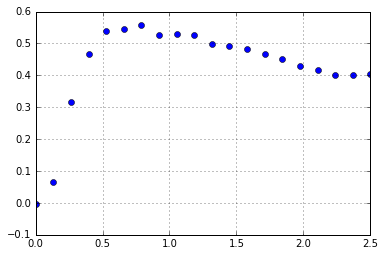

In [5]:
x = data[:,0]
y_obs = data[:,1]
plt.plot(x, y_obs , 'o');
plt.grid()

In [6]:
# define priors
a = pymc.Gamma('alpha',  alpha=10, beta=10)
b = pymc.Gamma('biot',  alpha=2, beta=1)
c = pymc.Gamma('tmax', alpha=10, beta=10)
tau = pymc.Normal("tau", mu=0.0, tau=0.2)

# define likelihood
@pymc.deterministic
def mu( a=a, b=b, c=c, x=x): # One dimensional model with heat losses
    
    # calculate eigenvalues - root of the transcendental functions
    gamas = mroots(funA, b, 0.001, 200)
    
    Bi1 = b
    Bi2 = b

    g2 = list(np.array(gamas)**2)
    suma=0.0
    for i in range(0, len(gamas)):
       suma = suma + 2*g2[i]*(g2[i]+Bi2**2)/((g2[i]+Bi1**2)*(g2[i]+Bi2**2)
       +(Bi1+Bi2)*(g2[i]+Bi1*Bi2))*(np.cos(gamas[i])+Bi1/gamas[i]
       *np.sin(gamas[i]))*np.exp(-g2[i]*a*x/L**2)  
    
    return c*suma

y = pymc.Normal('y', mu=mu, tau=tau, value=y_obs, observed=True)

# inference
m = pymc.Model([a, b, c, tau, x, y])
mc = pymc.MCMC(m)
mc.sample(iter=200, burn=10)

 [-----------------100%-----------------] 201 of 200 complete in 69.3 sec

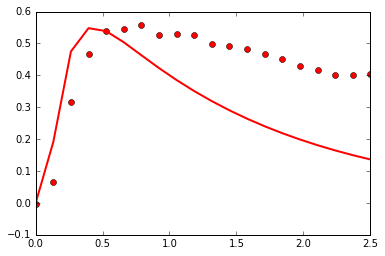

In [7]:
abar = a.stats()['mean']
bbar = b.stats()['mean']
cbar = c.stats()['mean']
plt.plot(x='x', y='y', kind='scatter', s=50);
xp = np.array(x)  #[x.min(), x.max()])
#plt.plot(xp, flash1DHL(a.trace(), b.trace(),c.trace(), xp[:, None]), c='red', alpha=0.01)
plt.plot(x,y_obs,'o',xp, flash1DHL(abar,bbar, cbar,xp), linewidth=2, c='red');

Plotting alpha
Plotting tmax
Plotting tau
Plotting biot


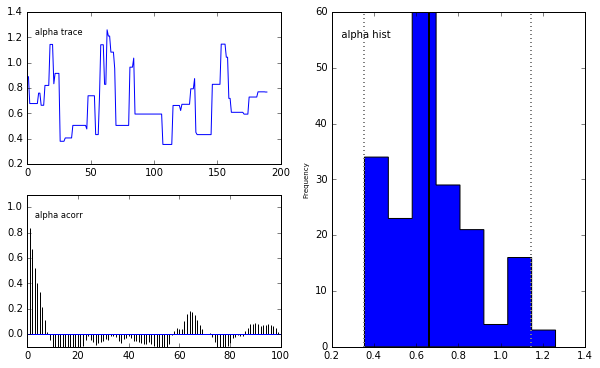

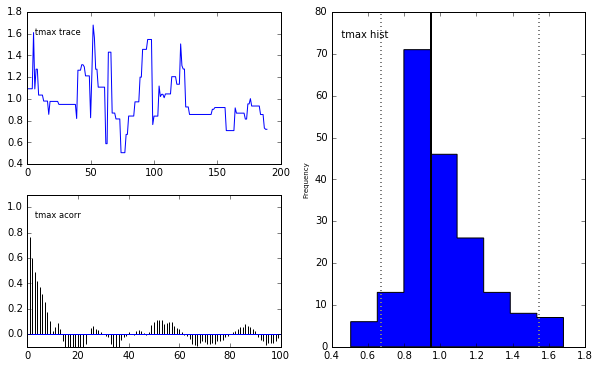

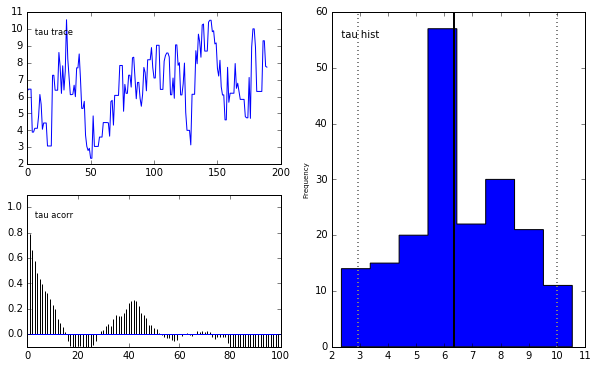

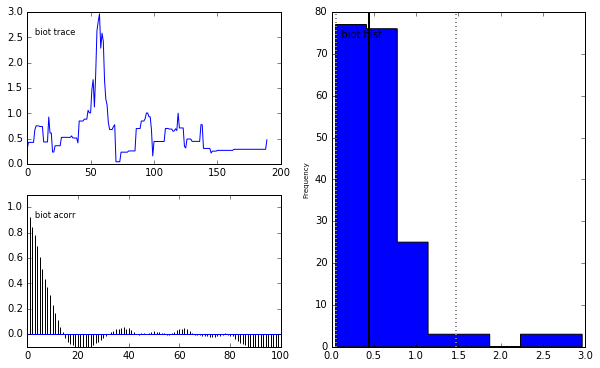

In [8]:
pymc.Matplot.plot(mc, )

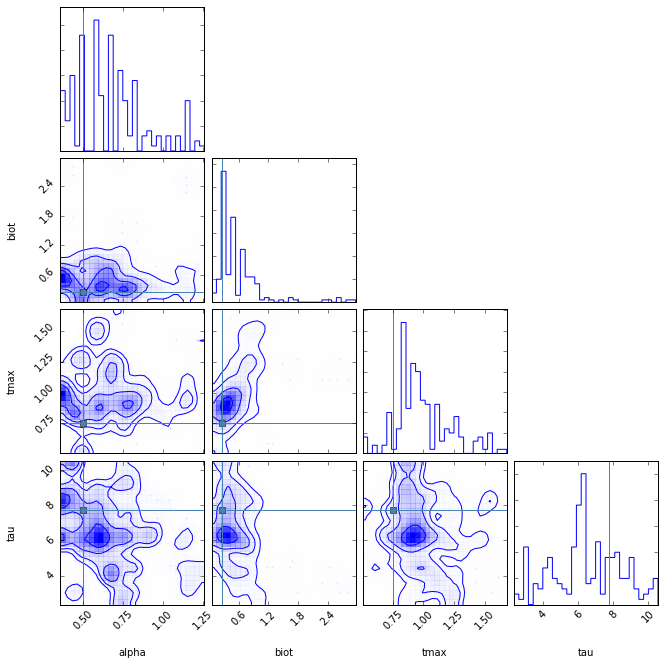

In [9]:

import numpy as np
samples = np.array([a.trace(),b.trace(), c.trace(), tau.trace()]).T
# pip install corner or pip install triangle_plot
import corner
figure = corner.corner(samples, color="b", bins=30, filled= True, smooth=(1.5),fill_contours=False,
                       labels=['alpha','biot', 'tmax', 'tau'], 
                truths=[0.5, 0.25,0.75, tau])

In [10]:
alpha_mean = a.stats()['mean']
Biot_mean= b.stats()['mean']
Tmax_mean = c.stats()['mean']
print('alpha = ',  alpha_mean, ', Biot = ',Biot_mean, ', Tmax = ',Tmax_mean)
print('alpha_theor = ',  a_theor, ', Biot_theor = ',b_theor, ', Tmax_theor = ',c_theor)

('alpha = ', 0.67370799263307013, ', Biot = ', 0.58675287652275132, ', Tmax = ', 0.99589037655002077)
('alpha_theor = ', 0.5, ', Biot_theor = ', 0.25, ', Tmax_theor = ', 0.75)
